In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
file_path_1 = './output/tarbase_om.z_1000.preppi.tsv'
file_path_2 = './output/tarbase_pm_mixed.z_1000.preppi.tsv'

df_1 = pd.read_csv(file_path_1, sep='\t', header=0)
df_2 = pd.read_csv(file_path_2, sep='\t', header=0)

In [3]:
mirna_origin_file_path = '../../MirGeneDB_miRNA_origin/hsa_mirgenedb3.0_to_everything.mirna_origin.tsv'
df_mirna_origin = pd.read_csv(mirna_origin_file_path, sep='\t', header=None)
# keep only columns 8,14,15 and remove duplicates
df_mirna_origin = df_mirna_origin[[8, 14, 15]]
df_mirna_origin = df_mirna_origin.drop_duplicates()
cols = ["miRNA", "locus_node_of_origin", "family_node_of_origin"]
df_mirna_origin.columns = cols
df_mirna_origin

mirna_lno_dict = {}
for index, row in df_mirna_origin.iterrows():
	mirna = row['miRNA']
	lno = row['family_node_of_origin']
	if mirna not in mirna_lno_dict:
		mirna_lno_dict[mirna] = []
	mirna_lno_dict[mirna].append(lno)

mirna_lno_dict['MIRLET7E'][0]

'Bilateria'

In [4]:
df_wgd = df_1
df_ssd = df_2

In [5]:
print("Number of WGD pairs: ", len(df_wgd))
print("Number of SSD pairs: ", len(df_ssd))

Number of WGD pairs:  137
Number of SSD pairs:  304


In [8]:
pre_2R_clades = ['Bilateria', 'Chordata', 'Eumetazoa', 'Vertebrata', 'Nephrozoa', 'Olphactores']

def all_clades_in_pre2R(mirna):
    clades = mirna_lno_dict.get(mirna, [])
    return all(clade in pre_2R_clades for clade in clades)

df_ssd = df_ssd[
    ~(
        df_ssd["miRNA"].apply(all_clades_in_pre2R)
    )
]

print("Number of WGD pairs: ", len(df_wgd))
print("Number of SSD pairs: ", len(df_ssd))

Number of WGD pairs:  137
Number of SSD pairs:  99


In [10]:
def remove_mirna_pairs(df1, df2):
	"""
	Removes from df1 all rows whose (miRNA_1, miRNA_2) pairs (regardless of order)
	are present in df2.
	"""
	# Create a set of tuples for the miRNA pairs in df2
	mirna_pairs = set()
	for _, row in df2.iterrows():
		mirna1 = row['miRNA']

	# Filter df1 to remove rows with miRNA pairs present in df2
	filtered_df = df1[~df1.apply(lambda row: tuple(sorted([row['miRNA']])) in mirna_pairs, axis=1)]
	
	return filtered_df


df_ssd = remove_mirna_pairs(df_ssd, df_wgd)

In [11]:
print("Number of WGD pairs after removing miRNA pairs from SSD: ", len(df_wgd))
print("Number of SSD pairs after removing miRNA pairs from SSD: ", len(df_ssd))

Number of WGD pairs after removing miRNA pairs from SSD:  137
Number of SSD pairs after removing miRNA pairs from SSD:  99


In [12]:
# if the column Z-score is equal to "sigma_err" and the column "n_relevant_delta" is equal to 0, then the Z-score is equal to 0
def remove_sigma_err(df):
    # Step 1: Set Z-score to 0 if Z-score == 'sigma_err' and n_relevant_delta == 0
    mask_fix = (df['Z-score'] == 'sigma_err') & (df['n_relevant_delta'] == 0)
    df.loc[mask_fix, 'Z-score'] = 0

    # Step 2: Remove rows where Z-score == 'sigma_err' and n_relevant_delta != 0
    mask_remove = (df['Z-score'] == 'sigma_err') & (df['n_relevant_delta'] != 0)
    df = df[~mask_remove]

    return df

df_wgd = remove_sigma_err(df_wgd)
df_ssd = remove_sigma_err(df_ssd)

In [15]:
# remove from bot datasets those rows where the second column is "not_in_G"
df_wgd = df_wgd[df_wgd.iloc[:, 1] != "not_in_G"]
df_ssd = df_ssd[df_ssd.iloc[:, 1] != "not_in_G"]

df_wgd_zscores = df_wgd['Z-score'].astype(float)
df_ssd_zscores = df_ssd['Z-score'].astype(float)

In [16]:
df_wgd_ndelta = df_wgd['n_relevant_delta'].astype(int)
df_ssd_ndelta = df_ssd['n_relevant_delta'].astype(int)

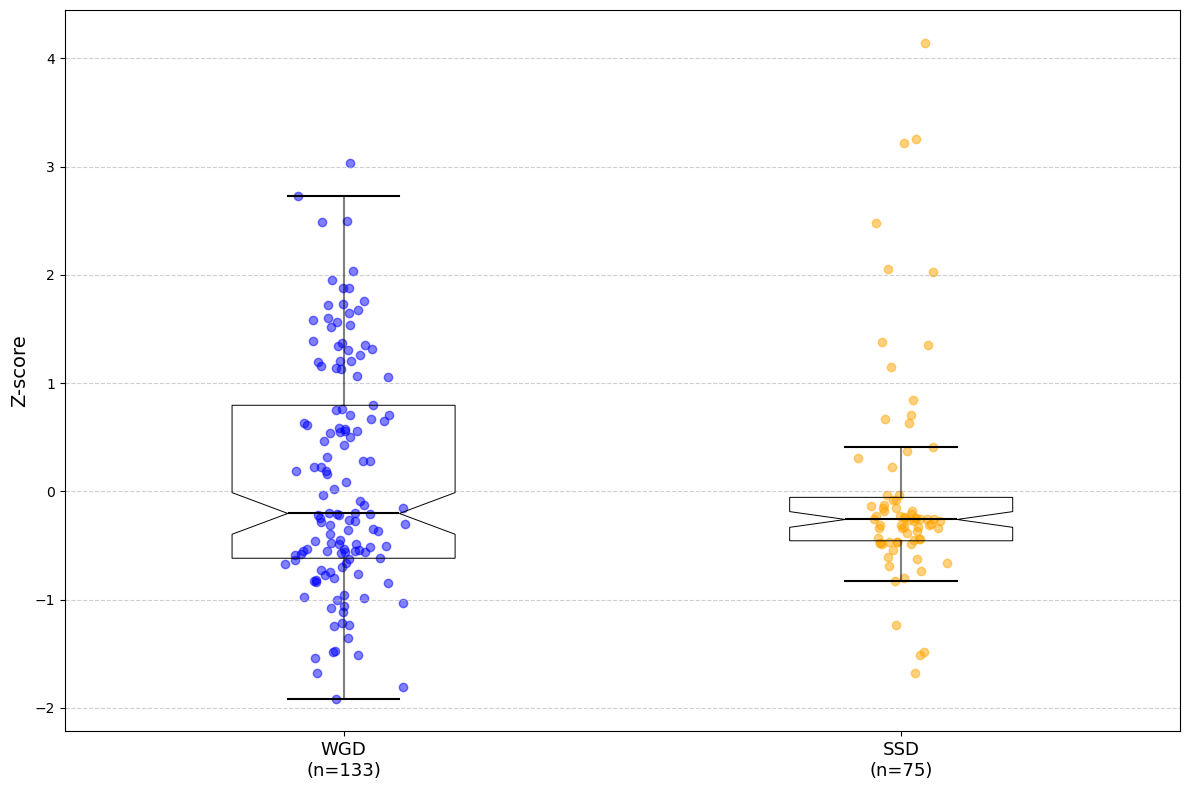

In [17]:
# Sample sizes
n_wgd = len(df_wgd_zscores)
n_ssd = len(df_ssd_zscores)

# Jittered x positions
x_wgd = np.random.normal(0, 0.04, size=n_wgd)
x_ssd = np.random.normal(1, 0.04, size=n_ssd)

plt.figure(figsize=(12, 8))

# Boxplot with transparent fill and notches
box = plt.boxplot(
    [df_wgd_zscores, df_ssd_zscores],
    positions=[0, 1],
    widths=0.4,
    notch=True,
    patch_artist=True,
    showfliers=False
)

# Make boxes transparent
for patch in box['boxes']:
	patch.set_facecolor('none')
	patch.set_edgecolor('black')
	patch.set_linewidth(0.7)

# Customize other boxplot parts
for element in ['medians', 'whiskers', 'caps']:
    for line in box[element]:
        line.set_color('black')
        line.set_linewidth(1.5)
        # width of the whiskers
        if element == 'whiskers':
            line.set_alpha(0.5)

# Jittered dots
plt.scatter(x_wgd, df_wgd_zscores, alpha=0.5, color='blue', label='WGD')
plt.scatter(x_ssd, df_ssd_zscores, alpha=0.5, color='orange', label='SSD')

# Labels
plt.ylabel('Z-score', fontsize=14)
plt.xticks([0, 1], [f'WGD\n(n={n_wgd})', f'SSD\n(n={n_ssd})'], fontsize=13)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [18]:
ks_stat, ks_p_value = stats.ks_2samp(df_wgd_zscores, df_ssd_zscores)
print(f"KS statistic: {ks_stat}, p-value: {ks_p_value}")

KS statistic: 0.23197994987468673, p-value: 0.009207444646280833


In [19]:
# print the SSD pairs with Z-score > 3
df_ssd_high_z = df_ssd[df_ssd['Z-score'].astype(float) > 1]
df_ssd_high_z

,miRNA,n_targets,mu,sigma,n_relevant_delta,n_maj_true,Z-score,pValue (nm size=1000)
77,MIR196B,145,0.273,0.5389536158149418,1,232,1.3489101448938545,0.031128881348366666
115,MIR299,105,0.164,0.40632991521668693,1,151,2.057441425532696,0.0006504038211943008
167,MIR377,260,0.914,0.941596516561101,2,231,1.1533602566482397,0.23264420541762698
168,MIR379,88,0.122,0.3537174013248429,1,113,2.482207538310145,0.0002762563816558483
170,MIR381,73,0.055,0.22798026230356,1,55,4.145095678246544,4.006268983225425e-09
174,MIR411,80,0.082,0.28508945964381077,1,79,3.2200418814043292,1.7643858598592743e-06
175,MIR412,211,0.579,0.7428048195858721,3,20,3.2592680286454714,0.0029603580305689325
256,MIR532,144,0.278,0.5241335707622629,1,245,1.3775114594357583,0.03217466210467923
257,MIR539,116,0.174,0.4070921271653383,1,164,2.0290247461959012,0.000771027712248129


In [20]:
df_wgd_high_z = df_wgd[df_wgd['Z-score'].astype(float) > 3]
df_wgd_high_z

,miRNA,n_targets,mu,sigma,n_relevant_delta,n_maj_true,Z-score,pValue (nm size=1000)
95,MIR301B,157,0.322,0.5534582188386039,2,40,3.0318458428915807,0.0003466965495346752


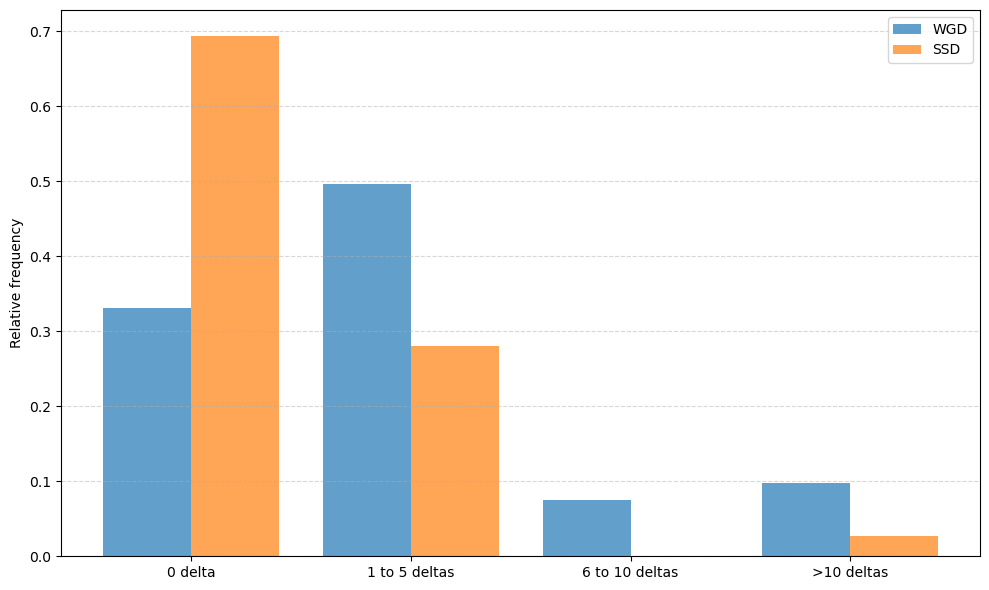

In [21]:
def bin_deltas(count):
    if count == 0:
        return '0'
    elif 1 <= count <= 5:
        return '1–5'
    elif 6 <= count <= 10:
        return '6–10'
    else:
        return '>10'

# Bin the counts
wgd_binned = pd.Series(df_wgd_ndelta).apply(bin_deltas)
ssd_binned = pd.Series(df_ssd_ndelta).apply(bin_deltas)

# Get relative frequencies for each bin
wgd_freq = wgd_binned.value_counts(normalize=True).reindex(['0', '1–5', '6–10', '>10'], fill_value=0)
ssd_freq = ssd_binned.value_counts(normalize=True).reindex(['0', '1–5', '6–10', '>10'], fill_value=0)

# Plot
labels = ['0 delta', '1 to 5 deltas', '6 to 10 deltas', '>10 deltas']
x = np.arange(len(labels))
width = 0.4

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, wgd_freq, width=width, label='WGD', alpha=0.7)
plt.bar(x + width/2, ssd_freq, width=width, label='SSD', alpha=0.7)

plt.xticks(x, labels)
plt.xlabel('')
plt.ylabel('Relative frequency')
plt.title('')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()